In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import string

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


#Visualizations library
import seaborn as sns 
import matplotlib.pyplot as plt


#Stats library
from scipy import stats
from scipy.stats import norm, skew 

#Preprocessing Libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn.feature_extraction.text import CountVectorizer


# Modellling Librries
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LassoCV, Ridge, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV 

import os
# print(os.listdir("../House Price Predictor"))

# Any results you write to the current directory are saved as output.

In [65]:
sales = pd.read_csv('kc_house_data.csv')
# sales = sales.sort_values(by=['sqft_living','price'])
testData = pd.read_csv('kc_house_test_data.csv')
trainData = pd.read_csv('kc_house_train_data.csv')

In [66]:
def convertToArray(df, feats,output):
    df['constant'] = 1
    feats = ['constant'] + feats
    featMatrix = df[feats].as_matrix()
    outputArray = df[output].as_matrix()
    return(featMatrix, outputArray)

In [67]:
def polyFeat(feat, degree):
    df = pd.DataFrame()
    if degree > 0:
        for pwr in range(1, degree+1):
            name = 'power_' + str(pwr)
            df[name] = feat ** pwr
    return df

In [68]:
def predictOutcome(featMatrix, weights):
    predictions = np.dot(featMatrix, weights)
    return predictions

In [69]:
def featDerRidge(wt, feat, errors, l2p, isConstant):
    der = -2 * np.dot(feat,errors)
    if not isConstant:
#         der = der + (2 * l2p * (np.sum(wt)))
        der = der + (2 * l2p * wt)
    return der

In [70]:
def getRSS(output, predictions):
    RSS = np.sum(np.square(output-predictions))
    return RSS

In [71]:
def ridgeGradDesc(featMat, op, initWt, stepSz, l2p, maxIter=100):
    wts =np.array(initWt)
    iter = 1
    while iter != maxIter:
        prediction = predictOutcome(featMat, wts)
        errors = op - prediction
        
        for i in range(len(wts)):
            isConstant = (i==0)
            der = featDerRidge(wts[i], featMat[:, i], errors, l2p, isConstant)
            wts[i] = wts[i] - (stepSz * der)
        iter = iter + 1
    return wts

In [72]:
exFeat, exOp = convertToArray(sales, ['sqft_living'], 'price')
myWt = np.array([1., 10.])
testPrediction = predictOutcome(exFeat, myWt)

/home/saurabh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/home/saurabh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [74]:
featDerRidge(myWt[0], exFeat[:,0], exOp-testPrediction,  1, True)

-22446749330.0

In [75]:
print (np.sum(testPrediction - exOp)*2)

-22446749330.0


In [76]:
simpFeat = ['sqft_living']
myOp = 'price'
simpTrMat, simpTrOp = convertToArray(trainData, simpFeat, myOp)
simpTeMat, simpTeOp = convertToArray(testData, simpFeat, myOp)

/home/saurabh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/home/saurabh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [77]:
stepSz = 1e-12
maxIter = 1000
initWts = np.array([0.0, 0.0])
l2p = 0.0
simpWts0Pe = ridgeGradDesc(simpTrMat, simpTrOp, initWts, stepSz, l2p, maxIter)

In [78]:
simpWts0Pe

array([-1.62844700e-01,  2.63024369e+02])

In [79]:
stepSz = 1e-12
maxIter = 1000
initWts = np.array([0.0, 0.0])
l2p = 1e11
simpWtsHiPe = ridgeGradDesc(simpTrMat, simpTrOp, initWts, stepSz, l2p, maxIter)

In [80]:
simpWtsHiPe

array([  9.75756033, 124.57217753])

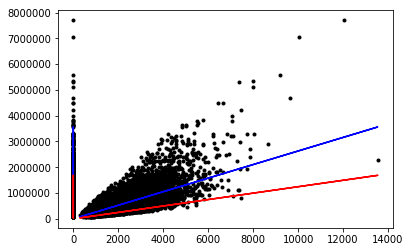

In [81]:
plt.plot(simpTrMat, simpTrOp, 'k.',
        simpTrMat, predictOutcome(simpTrMat, simpWts0Pe), 'b-',
        simpTrMat, predictOutcome(simpTrMat, simpWtsHiPe), 'r-')

In [91]:
testPred = predictOutcome(simpTeMat, simpWts0Pe)
RSSTest = getRSS(simpTeOp, testPred)
print(RSSTest)

275723632163972.25


In [83]:
simp1Feat = ['sqft_living', 'sqft_living15']
myOp = 'price'
simp1TrMat, simp1TrOp = convertToArray(trainData, simp1Feat, myOp)
simp1TeMat, simp1TeOp = convertToArray(testData, simp1Feat, myOp)

/home/saurabh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/home/saurabh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [84]:
stepSz = 1e-12
maxIter = 1000
initWts = np.array([0.0, 0.0, 0.0])
l2p = 0.0
simp1Wts0Pe = ridgeGradDesc(simp1TrMat, simp1TrOp, initWts, stepSz, l2p, maxIter)

In [85]:
stepSz = 1e-12
maxIter = 1000
initWts = np.array([0.0, 0.0, 0.0])
l2p = 1e11
simp1WtsHiPe = ridgeGradDesc(simp1TrMat, simp1TrOp, initWts, stepSz, l2p, maxIter)

In [86]:
print(simp1Wts0Pe[1])
print(simp1WtsHiPe[1])

243.05260393007475
91.48927454407048


In [90]:
test1Pred = predictOutcome(simp1TeMat, simp1WtsHiPe)
RSSTest1 = getRSS(simp1TeOp, test1Pred)
print(RSSTest1)

500404804222367.3


In [89]:
test2Pred = predictOutcome(simp1TeMat, simp1Wts0Pe)
print(test1Pred[0], test2Pred[0], simp1TeOp[0])

270453.52649706847 387466.2635739254 310000.0
